In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from keras.preprocessing import image

import matplotlib.image as mpimg
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
train_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/train/train"
validation_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/validation/validation"
test_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test"

creating data generators

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)  
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [5]:
df = pd.read_csv("/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/trainingset_v1d1_metadata.csv")
df.label.value_counts()

Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Extremely_Loud          447
Low_Frequency_Lines     447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
None_of_the_Above        81
1400Ripples              81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: label, dtype: int64

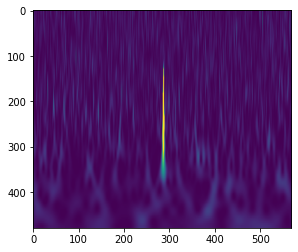

In [6]:
fullpath = train_dir + "/Blip/" + os.listdir(train_dir + "/Blip")[0]
img = mpimg.imread(fullpath)
plt.imshow(img)

getting the class names

In [7]:
classes_list = df.label.value_counts().index
classes_list = list(classes_list)
classes_list

['Blip',
 'Koi_Fish',
 'Low_Frequency_Burst',
 'Light_Modulation',
 'Power_Line',
 'Extremely_Loud',
 'Low_Frequency_Lines',
 'Scattered_Light',
 'Violin_Mode',
 'Scratchy',
 '1080Lines',
 'Whistle',
 'Helix',
 'Repeating_Blips',
 'No_Glitch',
 'Tomte',
 'None_of_the_Above',
 '1400Ripples',
 'Chirp',
 'Air_Compressor',
 'Wandering_Line',
 'Paired_Doves']

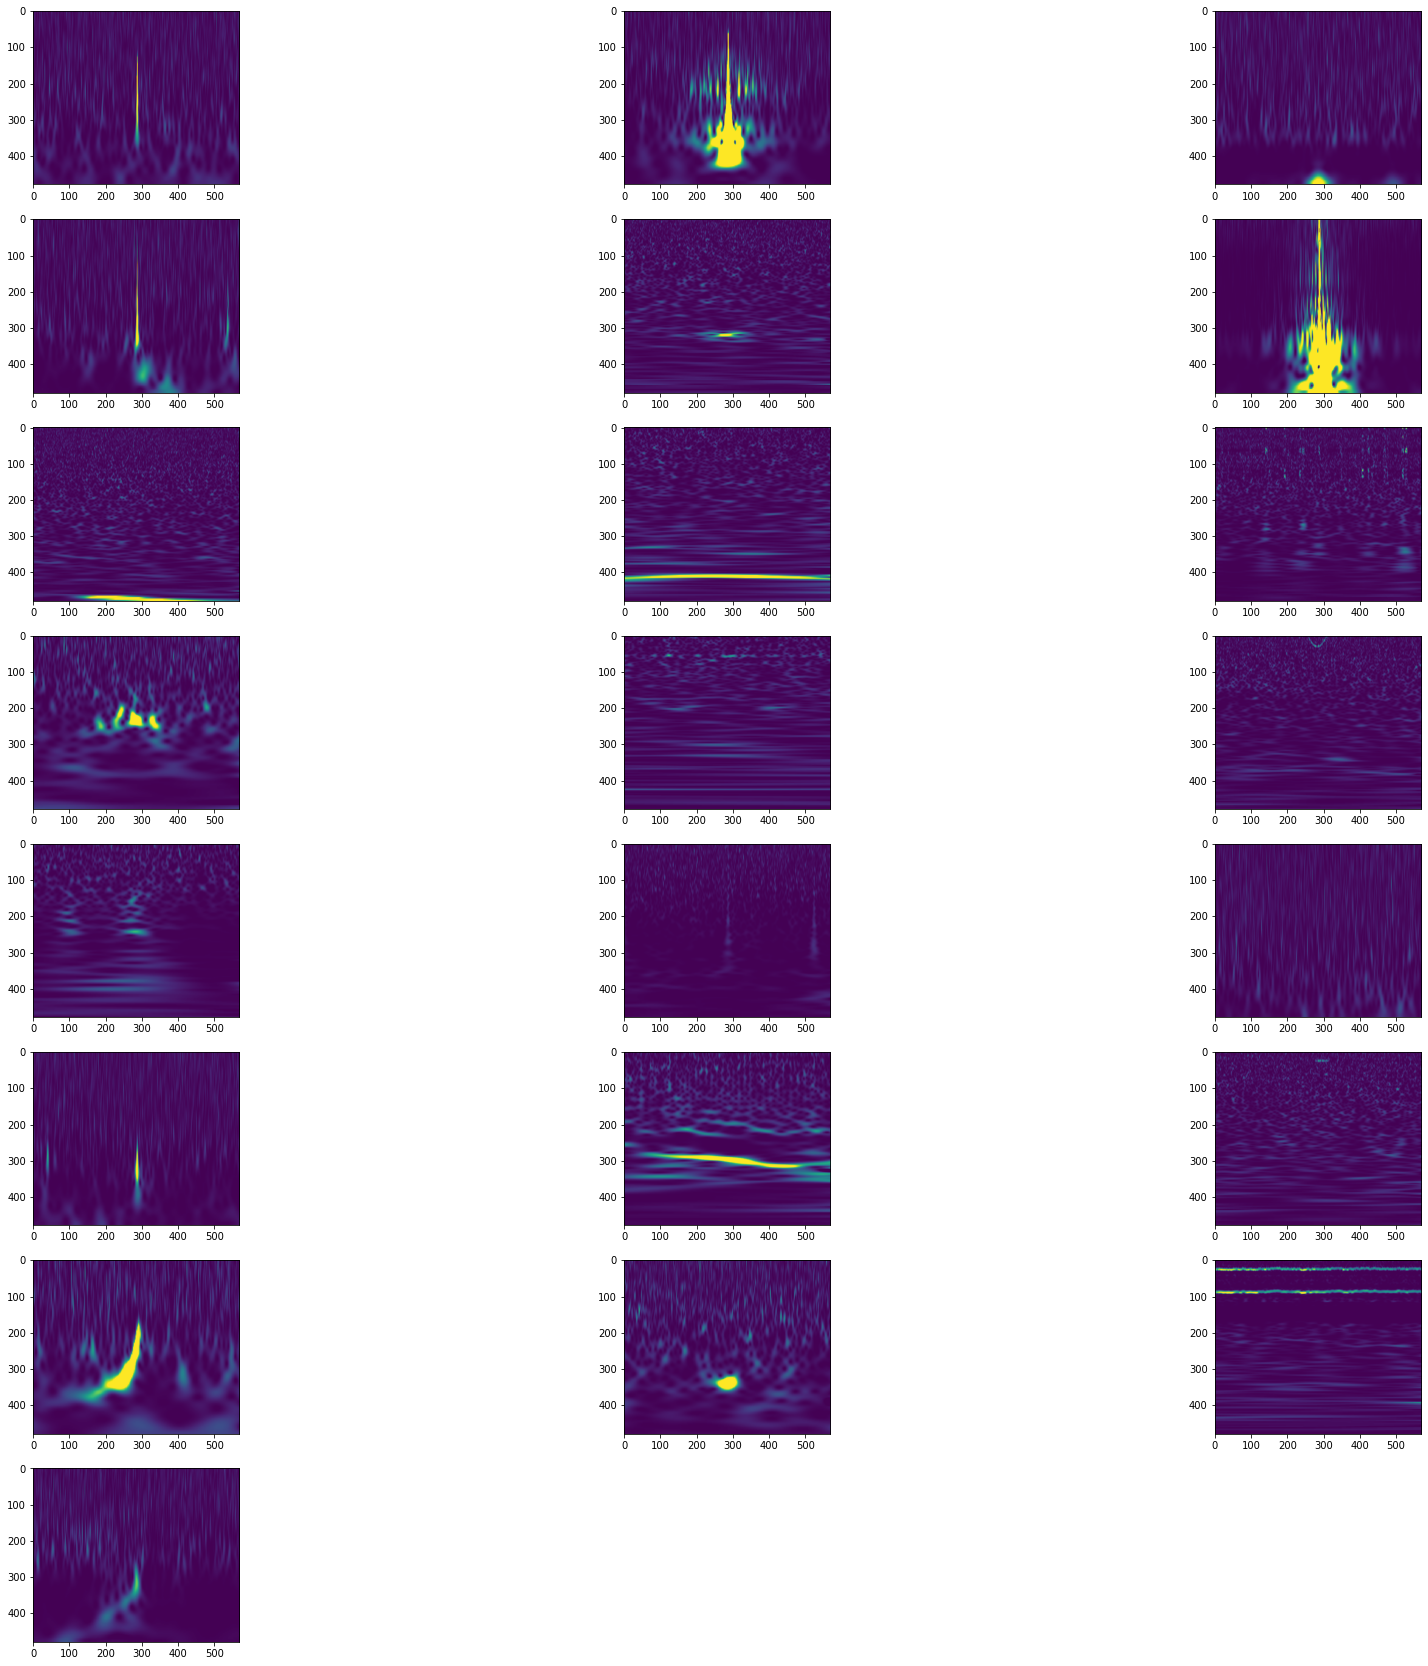

In [8]:
plt.figure(figsize=(30, 30))
    
for i in range(0, 22):
    plt.subplot(8, 3, i+1)
    fullpath = train_dir + "/" + classes_list[i] + '/' + os.listdir(train_dir + "/" + classes_list[i])[0]
    img=mpimg.imread(fullpath)
    plt.imshow(img)

In [9]:
training_batch_size = 10
validation_batch_size = 10
img_dim = 250

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  classes = classes_list,
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 22348 images belonging to 22 classes.


In [10]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 4800 images belonging to 22 classes.


In [11]:
test_size = !find '/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test' -type f | wc -l
test_size = int(test_size[0])
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 4720 images belonging to 22 classes.


In [12]:
input_shape = (img_dim, img_dim, 3)

base_model = tf.keras.applications.ResNet101V2(
    weights="imagenet",
    include_top=False,
    input_shape = input_shape
)
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(22, activation="softmax"))

model.layers[0].trainable = False

model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = [tf.keras.metrics.AUC(name='auc')]
)
model.summary()

171327488/171317808 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 8, 8, 2048)        42626560  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dense_1 (Dense)              (None, 22)                11286     
Total params: 109,755,414
Trainable params: 67,124,758


In [13]:
training_step_size = 32
validation_step_size = 32
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_auc",
    mode = "max",
    patience = 10
)
history = model.fit(
    train_generator,
    steps_per_epoch = training_step_size,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_step_size,
    callbacks = [early_stopping],
    verbose = 1,
)

print("Training Done")

Epoch 1/100
32/32 [==============================] - 233s 6s/step - loss: 9.2935 - auc: 0.7849 - val_loss: 30.9917 - val_auc: 0.6896
Epoch 2/100
32/32 [==============================] - 186s 6s/step - loss: 3.7121 - auc: 0.8816 - val_loss: 7.5639 - val_auc: 0.8280
Epoch 3/100
32/32 [==============================] - 182s 6s/step - loss: 2.5064 - auc: 0.8978 - val_loss: 2.1918 - val_auc: 0.9327
Epoch 4/100
32/32 [==============================] - 176s 6s/step - loss: 1.7632 - auc: 0.9360 - val_loss: 2.0560 - val_auc: 0.9428
Epoch 5/100
32/32 [==============================] - 169s 5s/step - loss: 1.2789 - auc: 0.9503 - val_loss: 2.0509 - val_auc: 0.9468
Epoch 6/100
32/32 [==============================] - 184s 6s/step - loss: 1.1344 - auc: 0.9568 - val_loss: 1.2569 - val_auc: 0.9560
Epoch 7/100
32/32 [==============================] - 157s 5s/step - loss: 0.9868 - auc: 0.9685 - val_loss: 1.3092 - val_auc: 0.9643
Epoch 8/100
32/32 [==============================] - 155s 5s/step - loss: 0

In [14]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [15]:
# test_scores = model.evaluate(test_generator, steps = test_size, verbose = 1)

In [16]:

# print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

classes = classes_list
train_hist = history
test_gen = test_generator

y_actual = test_generator.classes

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)

# Evaluate the results:
test_loss, test_metric = model.evaluate(test_gen,verbose = False)
results       = test_metric*100 
results_title ="\n Model AUC on Test Data:{}%".format(results)
print(results_title.format(results))
print(len(results_title) * "-")
    
# print classification report
print(classification_report(y_actual, y_pred, target_names=classes))


 Model AUC on Test Data:98.42026829719543%
-------------------------------------------
                     precision    recall  f1-score   support

               Blip       0.93      0.97      0.95      1092
           Koi_Fish       0.91      0.94      0.92       408
Low_Frequency_Burst       0.93      0.86      0.89       360
   Light_Modulation       0.89      0.87      0.88       312
         Power_Line       0.87      1.00      0.93       272
     Extremely_Loud       0.89      0.89      0.89       256
Low_Frequency_Lines       0.86      0.88      0.87       264
    Scattered_Light       0.94      0.92      0.93       268
        Violin_Mode       0.85      0.91      0.88       256
           Scratchy       0.89      0.97      0.93       200
          1080Lines       0.99      0.73      0.84       200
            Whistle       0.93      0.89      0.91       180
              Helix       0.87      1.00      0.93       168
    Repeating_Blips       0.81      0.74      0.78       

In [18]:
# extract data from training history for plotting
history_dict    = train_hist.history
loss_values     = history_dict['loss']
val_loss_values = history_dict['val_loss']
auc_values      = history_dict['auc']
val_auc_values  = history_dict['val_auc']
epochs          = range(1, len(history_dict['auc']) + 1)

# get the min loss and max auc for plotting
max_auc = np.max(val_auc_values)
min_loss = np.min(val_loss_values)
    

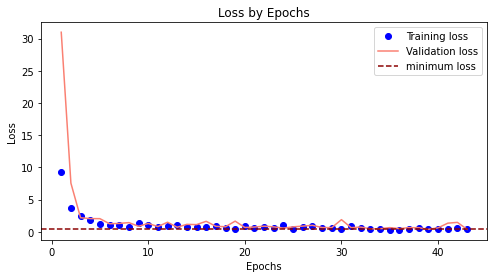

In [19]:
# create plots
plt.subplots(figsize=(8,4))

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'salmon', label = 'Validation loss')
plt.title('Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axhline(y=min_loss,color='darkred', linestyle='--', label = "minimum loss")
plt.legend()

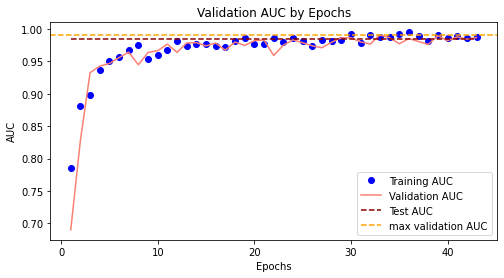

In [20]:
plt.subplots(figsize=(8,4))
plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
plt.plot(epochs, val_auc_values, 'salmon', label = 'Validation AUC')
plt.plot(epochs,[results/100]*len(epochs),'darkred',linestyle = '--',label='Test AUC')
plt.title('Validation AUC by Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.axhline(y=max_auc,color='orange', linestyle='--', label = "max validation AUC")
plt.legend()

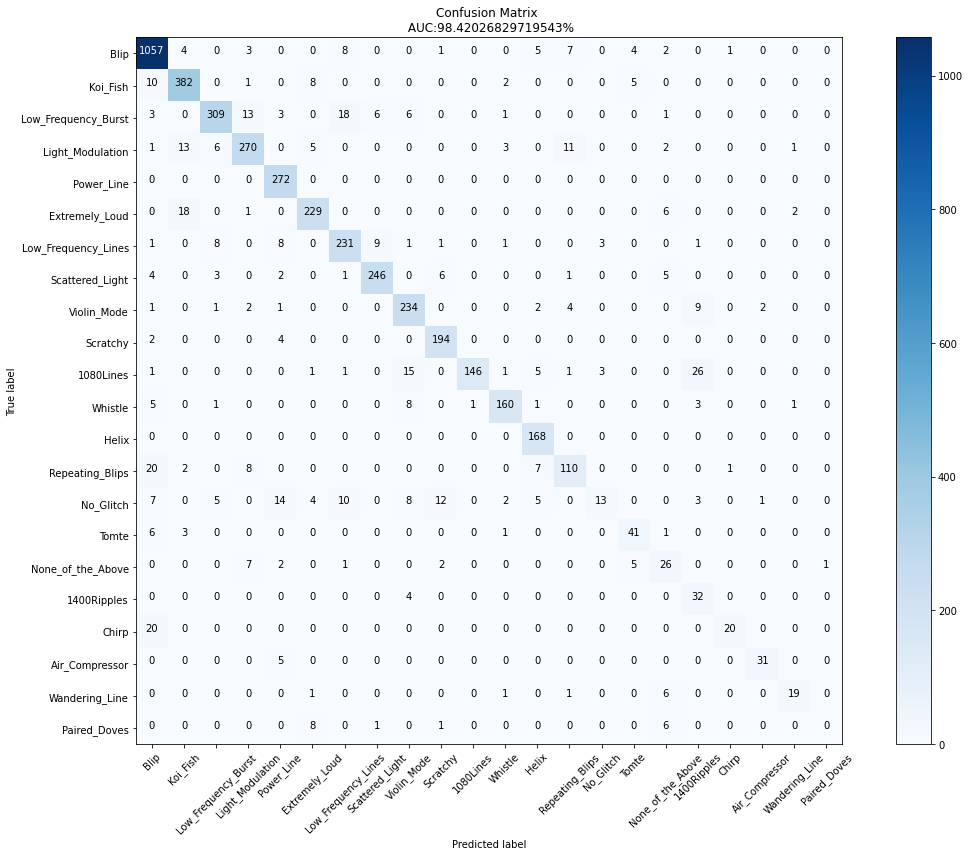

In [21]:
# calculate Confusion Matrix
cm = confusion_matrix(y_actual, y_pred)

# create confusion matrix plot
plt.subplots(figsize=(16,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix \n AUC:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(c, r, format(cm[r, c], 'd'),
              horizontalalignment="center",
              color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [22]:
from keras.utils.vis_utils import plot_model

plot_model(base_model, to_file="InceptionResNetV2_Base_Model.png", show_shapes=True, show_layer_names=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.800973 to fit

